In [63]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from gap.models.score_sde import ScoreModel3D, GScoreModel3D
from gap.ema import EMA
from gap.data import get_swiss_roll
from gap.purify import purify
from gap.geometry import get_distance_to_manifold

In [ ]:
data_norm = get_swiss_roll(5000)

In [26]:
train_data, test_data = train_test_split(data_norm, test_size=0.2, random_state=42)
train_tensor = torch.tensor(train_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

/var/folders/tb/dj89jjf13cd8hrrvfh09h7sr0000gn/T/ipykernel_82508/641710982.py:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/var/folders/tb/dj89jjf13cd8hrrvfh09h7sr0000gn/T/ipykernel_82508/641710982.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [30]:
# Initialize model and optimizer
model = ScoreModel3D()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Use the training set you created
dataset = train_tensor 

print("Training started...")
for epoch in range(20000):
    # 1. Sample data
    idx = torch.randint(0, len(dataset), (128,))
    x_clean = dataset[idx]
    
    # 2. Continuous Sigma Sampling
    # We sample log-sigma uniformly to cover all scales (0.01 to 1.0) evenly
    log_sigma = torch.rand(x_clean.shape[0], 1) * np.log(1.0/0.01) + np.log(0.01)
    sigma = torch.exp(log_sigma)
    
    # 3. Add Noise
    noise = torch.randn_like(x_clean)
    x_noisy = x_clean + sigma * noise
    
    # 4. Predict Score
    score_pred = model(x_noisy, sigma)
    
    # 5. Calculate Loss
    # Target is -noise / sigma (The direction pointing back to clean data)
    target_score = -noise / sigma
    
    # Weight loss by sigma^2 to stabilize training across scales
    loss = torch.mean(torch.sum((score_pred - target_score)**2, dim=-1) * (sigma.squeeze()**2))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

print("Training complete.")

Training started...
Epoch 0 | Loss: 3.0372
Epoch 1000 | Loss: 2.6734
Epoch 2000 | Loss: 2.5689
Epoch 3000 | Loss: 2.5208
Epoch 4000 | Loss: 2.0481
Epoch 5000 | Loss: 2.3257
Epoch 6000 | Loss: 2.5151
Epoch 7000 | Loss: 2.0060
Epoch 8000 | Loss: 1.9490
Epoch 9000 | Loss: 2.1718
Epoch 10000 | Loss: 1.9964
Epoch 11000 | Loss: 2.2841
Epoch 12000 | Loss: 2.3452
Epoch 13000 | Loss: 2.0792
Epoch 14000 | Loss: 2.1805
Epoch 15000 | Loss: 2.5734
Epoch 16000 | Loss: 1.9522
Epoch 17000 | Loss: 2.0746
Epoch 18000 | Loss: 2.0484
Epoch 19000 | Loss: 1.8489
Training complete.


In [ ]:
# Initialize model and optimizer
model = GScoreModel3D()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ema = EMA(model, decay=0.999)

# Use the training set you created
dataset = train_tensor 

print("Training started...")
for epoch in range(20000):
    # 1. Sample data
    idx = torch.randint(0, len(dataset), (128,))
    x_clean = dataset[idx]
    
    # 2. Continuous Sigma Sampling
    # We sample log-sigma uniformly to cover all scales (0.01 to 1.0) evenly
    log_sigma = torch.rand(x_clean.shape[0], 1) * np.log(1.0/0.01) + np.log(0.01)
    sigma = torch.exp(log_sigma)
    
    # 3. Add Noise
    noise = torch.randn_like(x_clean)
    x_noisy = x_clean + sigma * noise
    
    # 4. Predict Score
    score_pred = model(x_noisy, sigma)
    # 5. Calculate Loss
    # Target is -noise / sigma (The direction pointing back to clean data)
    target_term = score_pred * sigma + noise
    loss = torch.mean(torch.sum(target_term**2, dim=-1)) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ema.update(model)
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

print("Training complete.")

Training started...
Epoch 0 | Loss: 2.8595
Epoch 1000 | Loss: 2.7958
Epoch 2000 | Loss: 2.5195
Epoch 3000 | Loss: 2.3761
Epoch 4000 | Loss: 2.2843
Epoch 5000 | Loss: 2.4391
Epoch 6000 | Loss: 2.1420
Epoch 7000 | Loss: 2.1666
Epoch 8000 | Loss: 2.3250
Epoch 9000 | Loss: 2.3834
Epoch 10000 | Loss: 2.1263
Epoch 11000 | Loss: 2.0994
Epoch 12000 | Loss: 2.1279
Epoch 13000 | Loss: 2.2823
Epoch 14000 | Loss: 2.3141
Epoch 15000 | Loss: 1.8953
Epoch 16000 | Loss: 2.4495
Epoch 17000 | Loss: 2.2679
Epoch 18000 | Loss: 2.4424
Epoch 19000 | Loss: 2.3506
Training complete.


In [ ]:
ema.apply_shadow(model)

In [51]:
# 1. Select a random point from the Test Set
clean_idx = torch.randint(0, len(test_tensor), (1,))
clean_point = test_tensor[clean_idx]

# 2. Create the Adversarial Attack
# We push it into the empty space of the Swiss Roll (e.g., inside the curve)
# You can tweak this vector to see different purification behaviors
perturbation = torch.tensor([[1.5, 0.0, 1.5]]) 
x_adv = clean_point + perturbation

print(f"Clean Point: {clean_point.numpy()}")
print(f"Adversarial Point: {x_adv.numpy()}")

Clean Point: [[ 1.6118555  -0.37538758 -0.0547305 ]]
Adversarial Point: [[ 3.1118555  -0.37538758  1.4452695 ]]


In [52]:
# 2. Run Purification
# We use a slightly higher learning rate to help it jump back from so far away
sigmas = torch.tensor([0.01])
trajectory_simple = purify(x_adv, model, sigmas, steps_per_sigma=5, lr=0.02, simple=True)

sigmas = torch.exp(torch.linspace(np.log(5.0), np.log(0.01), 20)) # Start at sigma=2.0 (very noisy)
trajectory_annealed = purify(x_adv, model, sigmas, steps_per_sigma=50, lr=0.02, simple=False)

In [ ]:
adv_dist, closest_to_adv = get_distance_to_manifold(x_adv, train_tensor)

purified_point_simple = torch.tensor(trajectory_simple[-1]).view(1, -1)
purified_point_annealed = torch.tensor(trajectory_annealed[-1]).view(1, -1)
pure_dist_simple, closest_to_pure_simple = get_distance_to_manifold(purified_point_simple, train_tensor)
pure_dist_annealed, closest_to_pure_annealed = get_distance_to_manifold(purified_point_annealed, train_tensor)

print("--- Simple Purification ---")
print(f"Attack Distance (Off-Manifold): {adv_dist:.4f}")
print(f"Purification Error (Distance to Manifold): {pure_dist_simple:.4f}")
print(f" Improvement Factor: {adv_dist / pure_dist_simple:.1f}x closer")
print("--- Annealed Purification ---")
print(f"Attack Distance (Off-Manifold): {adv_dist:.4f}")
print(f"Purification Error (Distance to Manifold): {pure_dist_annealed:.4f}")
print(f" Improvement Factor: {adv_dist / pure_dist_annealed:.1f}x closer")

--- Simple Purification ---
Attack Distance (Off-Manifold): 1.7482
Purification Error (Distance to Manifold): 0.8081
 Improvement Factor: 2.2x closer
--- Annealed Purification ---
Attack Distance (Off-Manifold): 1.7482
Purification Error (Distance to Manifold): 0.3094
 Improvement Factor: 5.7x closer


In [54]:
import plotly.graph_objects as go
import numpy as np

# Convert everything to numpy for plotting
manifold_np = train_tensor.numpy()
traj_simple_np = trajectory_simple
traj_annealed_np = trajectory_annealed
clean_np = clean_point.numpy()[0]
adv_np = x_adv.numpy()[0]

# Endpoints
pure_simple_np = traj_simple_np[-1]
pure_annealed_np = traj_annealed_np[-1]

# Nearest neighbors on manifold (ensure these variables are calculated in your previous cell)
closest_pure_simple_np = closest_to_pure_simple.numpy()
closest_pure_annealed_np = closest_to_pure_annealed.numpy()
closest_to_adv_np = closest_to_adv.numpy()

fig = go.Figure()

# 1. The Manifold (Swiss Roll) - RESTORED FULL DATASET
fig.add_trace(go.Scatter3d(
    x=manifold_np[:, 0], y=manifold_np[:, 1], z=manifold_np[:, 2],
    mode='markers',
    marker=dict(size=1.5, color=manifold_np[:,1], colorscale='Viridis', opacity=0.6),
    name='Swiss Roll Manifold'
))

# 2. Simple Purification Path (Fixed Sigma)
fig.add_trace(go.Scatter3d(
    x=traj_simple_np[:, 0], y=traj_simple_np[:, 1], z=traj_simple_np[:, 2],
    mode='lines',
    line=dict(color='orange', width=3),
    name='Simple Path (Fixed Sigma)'
))

# 3. Annealed Purification Path (Diffusion)
fig.add_trace(go.Scatter3d(
    x=traj_annealed_np[:, 0], y=traj_annealed_np[:, 1], z=traj_annealed_np[:, 2],
    mode='lines',
    line=dict(color='blue', width=5),
    name='Annealed Path (Diffusion)'
))

# 4. Key Markers
fig.add_trace(go.Scatter3d(
    x=[clean_np[0]], y=[clean_np[1]], z=[clean_np[2]],
    mode='markers', marker=dict(size=10, color='green'), name='Original Clean'
))
fig.add_trace(go.Scatter3d(
    x=[adv_np[0]], y=[adv_np[1]], z=[adv_np[2]],
    mode='markers', marker=dict(size=10, color='red', symbol='x'), name='Adversarial Input'
))
fig.add_trace(go.Scatter3d(
    x=[pure_simple_np[0]], y=[pure_simple_np[1]], z=[pure_simple_np[2]],
    mode='markers', marker=dict(size=8, color='orange', symbol='diamond'), name='Simple Result'
))
fig.add_trace(go.Scatter3d(
    x=[pure_annealed_np[0]], y=[pure_annealed_np[1]], z=[pure_annealed_np[2]],
    mode='markers', marker=dict(size=8, color='blue', symbol='circle'), name='Annealed Result'
))

# 5. Distance Metrics
# Initial Attack Distance
fig.add_trace(go.Scatter3d(
    x=[adv_np[0], closest_to_adv_np[0]], y=[adv_np[1], closest_to_adv_np[1]], z=[adv_np[2], closest_to_adv_np[2]],
    mode='lines', line=dict(color='red', width=2, dash='dot'),
    name=f'Initial Attack Dist: {adv_dist:.2f}'
))

# Simple Error Line
fig.add_trace(go.Scatter3d(
    x=[pure_simple_np[0], closest_pure_simple_np[0]], 
    y=[pure_simple_np[1], closest_pure_simple_np[1]], 
    z=[pure_simple_np[2], closest_pure_simple_np[2]],
    mode='lines', line=dict(color='orange', width=2, dash='dash'),
    name=f'Simple Final Error: {pure_dist_simple:.2f}'
))

# Annealed Error Line
fig.add_trace(go.Scatter3d(
    x=[pure_annealed_np[0], closest_pure_annealed_np[0]], 
    y=[pure_annealed_np[1], closest_pure_annealed_np[1]], 
    z=[pure_annealed_np[2], closest_pure_annealed_np[2]],
    mode='lines', line=dict(color='blue', width=2, dash='dash'),
    name=f'Annealed Final Error: {pure_dist_annealed:.2f}'
))

fig.update_layout(
    title="Comparison: Simple vs. Annealed Purification",
    scene=dict(aspectmode='data'),
    width=1000, height=800
)

fig.show()


<>:36: SyntaxWarning:

invalid escape sequence '\s'

<>:36: SyntaxWarning:

invalid escape sequence '\s'

/var/folders/tb/dj89jjf13cd8hrrvfh09h7sr0000gn/T/ipykernel_82508/3213381735.py:36: SyntaxWarning:

invalid escape sequence '\s'



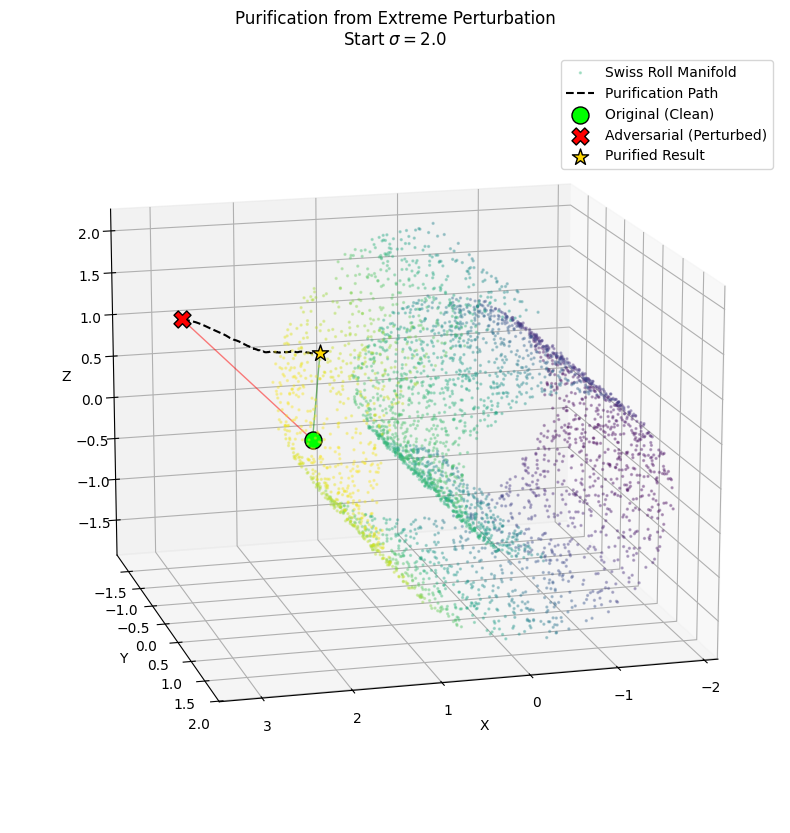

In [56]:
# Visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# --- BETTER MANIFOLD VISUALIZATION ---
# Instead of random scatter, we sort the points by the 1st dimension (the spiral)
# to make it look more like a connected surface.
d = train_tensor.numpy()
# Filter points to just show the "spine" of the roll for clarity
ax.scatter(d[:, 0], d[:, 1], d[:, 2], c=d[:, 0], cmap='viridis', s=2, alpha=0.3, label="Swiss Roll Manifold")

# --- PLOT THE JOURNEY ---
# Trajectory: Blue line with markers
ax.plot(trajectory_annealed[:, 0], trajectory_annealed[:, 1], trajectory_annealed[:, 2], 
        color='black', linewidth=1.5, linestyle='--', label="Purification Path")

# Start (Green) -> Attack (Red) -> End (Gold)
ax.scatter(clean_point[:, 0], clean_point[:, 1], clean_point[:, 2], 
           color='lime', s=150, edgecolors='black', label="Original (Clean)")
ax.scatter(x_adv[:, 0], x_adv[:, 1], x_adv[:, 2], 
           color='red', s=150, marker='X', edgecolors='black', label="Adversarial (Perturbed)")
ax.scatter(trajectory_annealed[-1, 0], trajectory_annealed[-1, 1], trajectory_annealed[-1, 2], 
           color='gold', s=150, marker='*', edgecolors='black', label="Purified Result")

# --- DRAW CONNECTOR LINES ---
# Draw a thin red line from Clean -> Adversarial (The "Attack")
ax.plot([clean_point[0,0], x_adv[0,0]], 
        [clean_point[0,1], x_adv[0,1]], 
        [clean_point[0,2], x_adv[0,2]], color='red', alpha=0.5, linewidth=1)

# Draw a thin green line from Purified -> Clean (The "Error")
ax.plot([trajectory_annealed[-1,0], clean_point[0,0]], 
        [trajectory_annealed[-1,1], clean_point[0,1]], 
        [trajectory_annealed[-1,2], clean_point[0,2]], color='green', alpha=0.5, linewidth=1)

ax.set_title(f"Purification from Extreme Perturbation\nStart $\sigma=2.0$")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

# Set a better view angle to see the 'gap' in the roll
ax.view_init(elev=15, azim=75)

plt.show()